In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

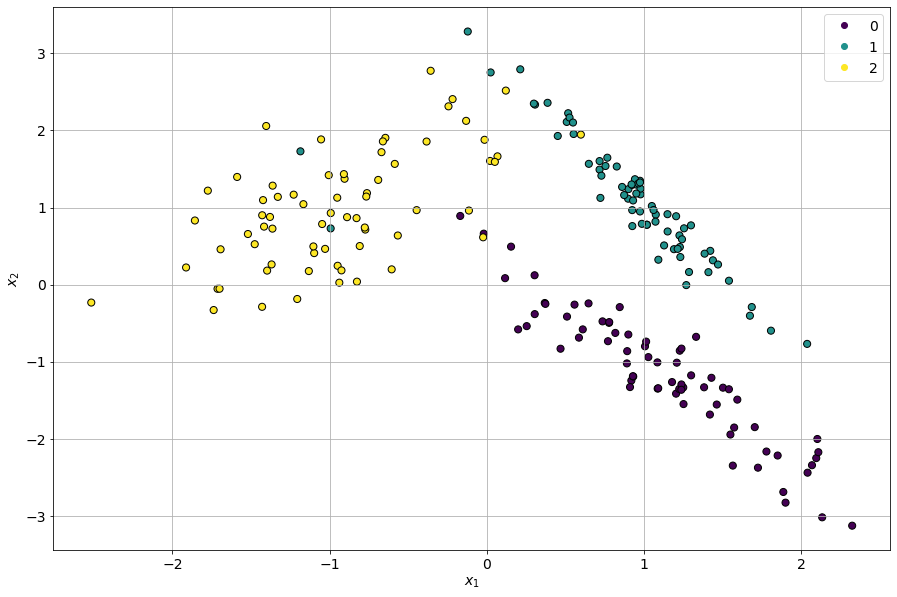

In [2]:
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=210,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=1,
    n_classes=3,
    random_state=RANDOM_STATE
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])

In [3]:
# TODO - напишите функции вычисления softmax и предсказания
def softmax(z):
    e=np.exp(z)
    z_norm=e/np.sum(e)
    return z_norm


def predict_proba(X, W):
    '''
    Предсказание нормированных степеней уверенности
    '''
    X1=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    z=X1@W
    y_proba=np.zeros((z.shape))
    for i in range(z.shape[0]):
        y_proba[i,:]=softmax(z[i,:])
    return y_proba


def predict(X, W):
    '''
    Предсказание индексов классов
    '''
    y=predict_proba(X,W)
    y_pred=np.argmax(y,axis=1)
    
    return y_pred

In [4]:
# Проверка
X = np.array([
    [1, 2],
    [-3, 4],
    [1, 2],
    [-1, 1],
    [0, 5],
    [0, -2],
])

W = np.array([
    [1, 2, 0],
    [0, 2, 1],
    [2, 2, 0]
])

y_prob = predict_proba(X, W)
y_pred = predict(X, W)

y_pred_true = np.array([1, 0, 1, 0, 1, 2])

assert np.all(y_pred == y_pred_true)
assert np.all(np.abs(np.sum(y_prob, axis=1)-np.ones(X.shape[0])) < 1e-8)

In [5]:
rand_W = np.array([
    [-1, -2, -2],
    [-7, 2, -3],
    [-1, 1, 4],
])

In [6]:
# TODO - произведите разделение данных
# NOTE - не забудьте зафиксировать RANDOM_STATE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_data,y_data,train_size=0.7, random_state=RANDOM_STATE,stratify=y_data)


In [7]:
# Проверка
assert np.all([
    X_train.shape[0] == 147, 
    X_test.shape[1] == X_data.shape[1], 
    y_test.shape[0] == 63,
    y_test[y_test == 2].shape[0] == 20
])

In [8]:
def plot_2d_decision_boundary(X, W, y_true):
    x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
    x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
    xx, yy = np.meshgrid(x1_vals, x2_vals)

    y_pred = predict(np.c_[xx.ravel(), yy.ravel()], W)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred)
    pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=30, edgecolor='k')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True)
    plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1','2'])
    plt.show()



def get_confusion_matrix(y_true, y_pred):
    # TODO - функция генерации матрицы ошибок по векторам предсказания/разметки
    #кол-во классов
    size=np.max(y_true)+1
    #квадратная матрица из нулей
    conf_mtrx=np.zeros((size,size),dtype=int)
    for i in range(size):
        for j in range(size):
            conf_mtrx[i,j]=np.sum((y_true==i)&(y_pred==j))
        conf_mtrx[i,i]=np.sum((y_true==i)&(y_pred==i))
        
    return conf_mtrx


def draw_confusion_matrix(conf_mtrx):
    # TODO - функция отображения матрицы ошибок
    ax = sns.heatmap(conf_mtrx, annot=True)
    plt.xlabel('Предсказанное')
    plt.ylabel('Истинное')
    plt.show()


# TODO - функции вычисления метрик 
def calculate_accuracy(y_true, y_pred):
    # TODO - функция вычисления точности
    conf_mtrx=get_confusion_matrix(y_true, y_pred)
    acc=np.sum(np.diag(conf_mtrx))/np.sum(conf_mtrx)
    return acc


def calculate_recall_precision_f1(y_true, y_pred, class_index):
    conf_mtrx=get_confusion_matrix(y_true,y_pred)
    precision=(conf_mtrx[class_index,class_index]/np.sum(conf_mtrx[:,class_index]))
    recall=(conf_mtrx[class_index,class_index]/np.sum(conf_mtrx[class_index,:]))
    f1=2*(precision*recall)/(precision+recall)
    return recall, precision, f1

In [9]:
X = X_test
y_true = y_test
y_pred = predict(X, rand_W)

print(f'Accuracy: {calculate_accuracy(y_true, y_pred)}')
print(f'Class 0 metrics: {calculate_recall_precision_f1(y_true, y_pred, 0)}')
print(f'Class 1 metrics: {calculate_recall_precision_f1(y_true, y_pred, 1)}')
print(f'Class 2 metrics: {calculate_recall_precision_f1(y_true, y_pred, 2)}')

Accuracy: 0.4126984126984127
Class 0 metrics: (0.047619047619047616, 0.08333333333333333, 0.060606060606060615)
Class 1 metrics: (0.6818181818181818, 0.4411764705882353, 0.5357142857142857)
Class 2 metrics: (0.5, 0.5882352941176471, 0.5405405405405405)


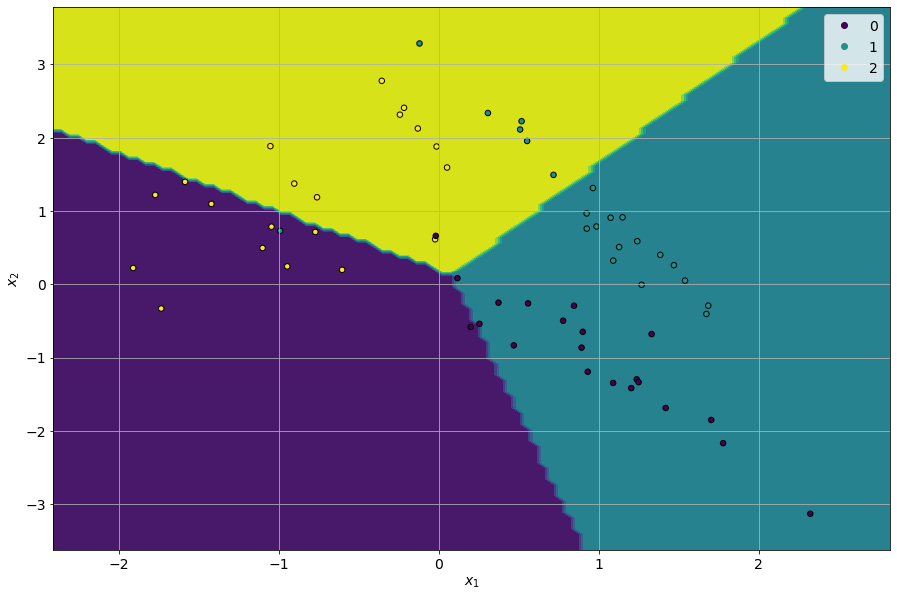

In [10]:
plot_2d_decision_boundary(X, rand_W, y_true)

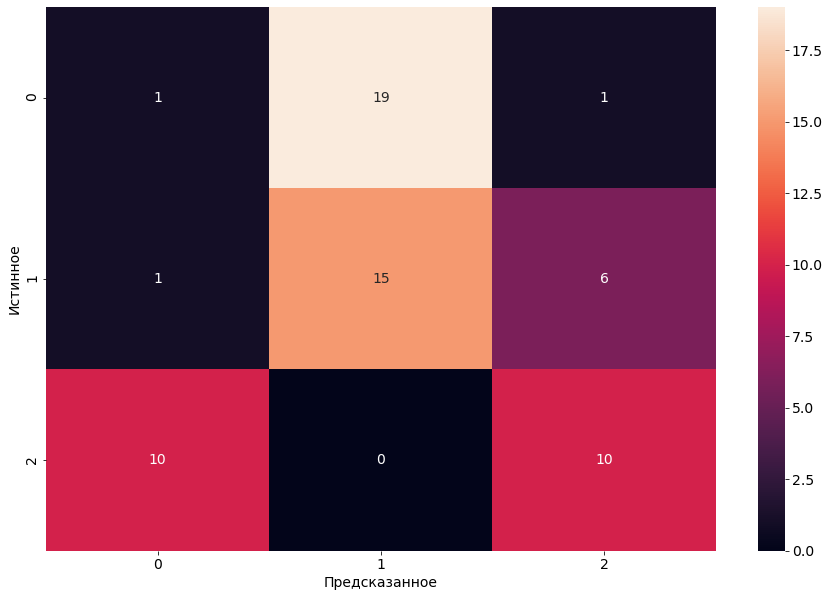

In [11]:
conf_mtrx = get_confusion_matrix(y_true, y_pred)
draw_confusion_matrix(conf_mtrx)

In [12]:
# TODO - функция кодирования вектора индексов классов в представление OHE
def onehot_encode(y):
    # NOTE - для получения размера вектора воспользуйтесь максимальным значением
    #   из вектора y
     # NOTE - для получения размера вектора воспользуйтесь максимальным значением
    #   из вектора y
    y_len=np.max(y)+1
    y_ohe=np.zeros((len(y),y_len))
    for i in range(len(y)):
        y_ohe[i,y[i]]=1
    return y_ohe

In [13]:
y_ohe = onehot_encode([1, 2, 1, 2, 1, 0])

y_ohe_true = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]
])
assert np.all(y_ohe == y_ohe_true)

In [14]:
#Категориальная кросс-энтропия
# TODO - функция потерь и функция получения матрицы производных
def cce_loss(y_true, y_pred_proba):
    y_ohe=onehot_encode(y_true)
    loss=-np.sum(y_ohe*np.log(y_pred_proba),axis=1)
    loss=np.mean(loss)
    return loss

def cce_loss_deriv(X, y_true, y_pred_proba):
    y_ohe=onehot_encode(y_true)
    dJ=X.T@(y_pred_proba-y_ohe)
    return dJ

In [15]:
# Проверка
y_true = np.array([0, 1, 2, 3])
y_pred_proba = np.array([
  [0.98, 0.01, 0.01, 1e-8],
  [0.6, 0.1, 1e-8, 0.3],
  [0.1, 0.2, 0.4, 0.3],
  [0.2, 0.1, 0.1, 0.6],
])

X = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [8, 9, 0],
    [7, 6, 5],
])

loss = cce_loss(y_true, y_pred_proba)
dJ = cce_loss_deriv(X, y_true, y_pred_proba)

dJ_true = np.array([
    [ 3.38      ,  0.51      , -4.08999998,  0.20000001],
    [ 3.86      , -0.28      , -4.77999997,  1.20000002],
    [ 3.34      , -3.07      ,  0.53000004, -0.79999997]
])

assert loss == 0.9374760389879278
assert np.all(np.abs(dJ-dJ_true) < 1e-8)

# Задание


Настало время обучить нашу модель и эта задача переходит вам! Давайте напишем функцию обучения модели. Учтите следующие особенности:

 - в ходе обучения применяется степень уверенности, а не конечный предсказанный класс;
 
 
 - функция predict_proba() принимает на вход исходные данные и сама добавляет колонку, функция сce_loss_deriv() более общая и не добавляет колонку единиц.

In [17]:
# TODO - функция обучения и функция отображения истории обучения
def fit_model(X, y, lr, n_iter):
    # Создаем 
    y_ohe = onehot_encode(y)
    K = y_ohe.shape[1]
    M = X.shape[1]+1
    W = np.zeros((M, K))
    X_linreg = np.c_[np.ones(X.shape[0]), X]
    loss_history = []
    # TODO - допишите код обучения
    for i in range(n_iter):
        y_pred=predict_proba(X, W)
        loss=cce_loss(y, y_pred)
        dJ=cce_loss_deriv(X_linreg, y, y_pred)
        W=W-lr*dJ
        loss_history.append(loss)
    return W, loss_history


def show_loss(loss_history):
    plt.plot(loss_history)
    plt.grid()
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('$J(X)$')
    plt.show()

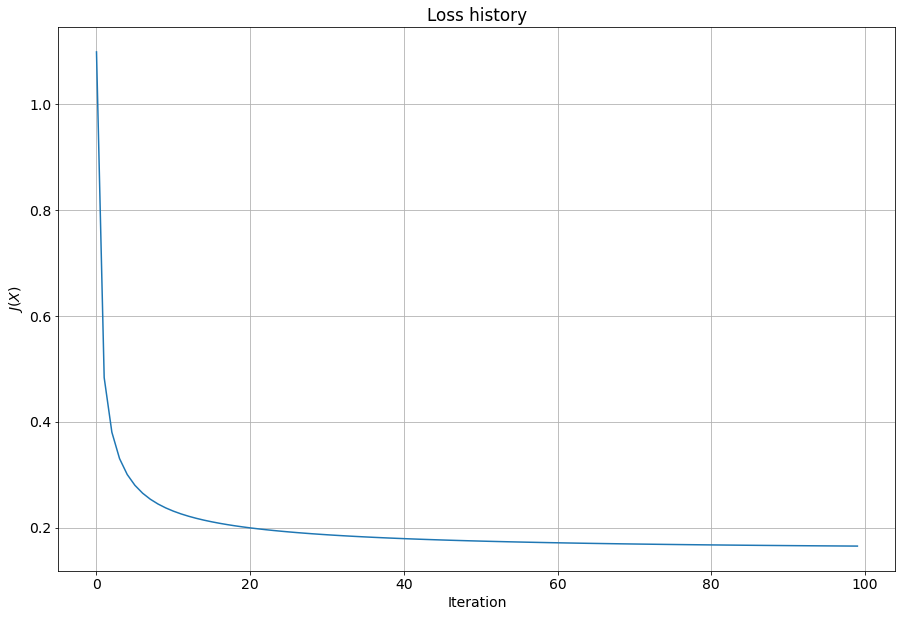

In [18]:
trained_W, loss_history = fit_model(
    lr=0.01,
    n_iter=100,
    X=X_train,
    y=y_train
)

show_loss(loss_history)

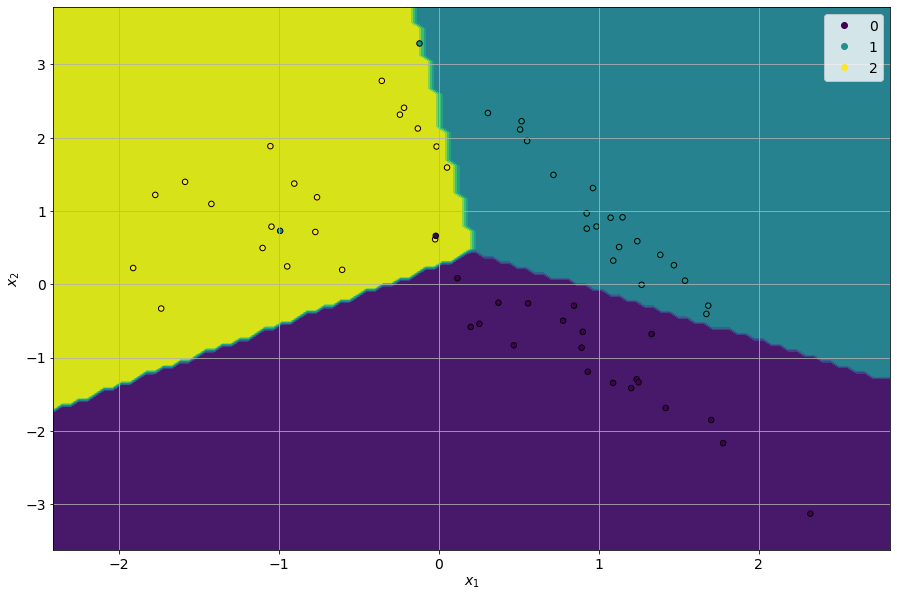

In [19]:
plot_2d_decision_boundary(X_test, trained_W, y_test)

Accuracy: 0.9523809523809523
Class 0 metrics: (0.9523809523809523, 1.0, 0.975609756097561)
Class 1 metrics: (0.9090909090909091, 1.0, 0.9523809523809523)
Class 2 metrics: (1.0, 0.8695652173913043, 0.9302325581395349)


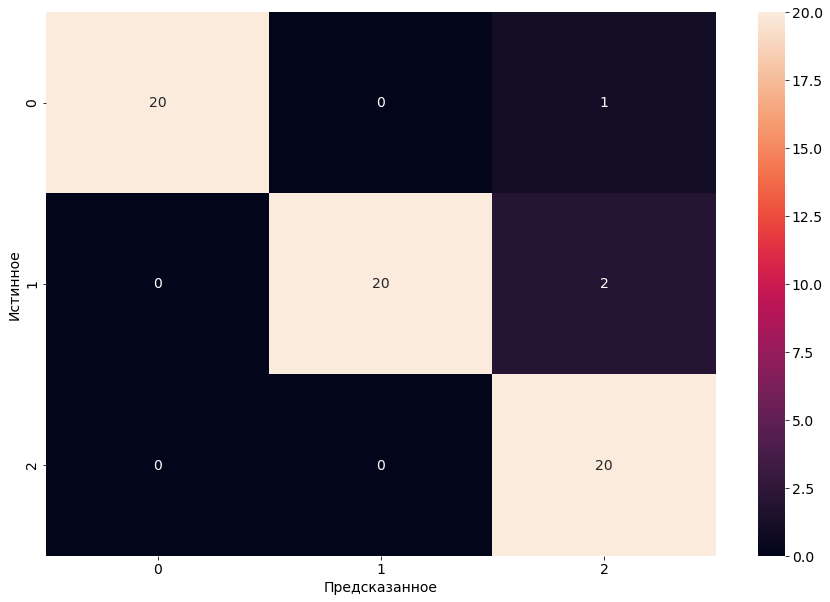

In [20]:
X = X_test
y_true = y_test
y_pred = predict(X, trained_W)

print(f'Accuracy: {calculate_accuracy(y_true, y_pred)}')
print(f'Class 0 metrics: {calculate_recall_precision_f1(y_true, y_pred, 0)}')
print(f'Class 1 metrics: {calculate_recall_precision_f1(y_true, y_pred, 1)}')
print(f'Class 2 metrics: {calculate_recall_precision_f1(y_true, y_pred, 2)}')

conf_mtrx = get_confusion_matrix(y_true, y_pred)
draw_confusion_matrix(conf_mtrx)

# Разработка модели с помощью класса

In [28]:
# TODO - реализуйте класс логистической регрессии
class LogisticRegression:
    def __init__(self):
        # В начале инициализируем веса как None, что означает "модель не обучена"
        self.W = None
        
    def softmax(self,z):
        z_norm=(np.exp(z)/np.sum(np.exp(z)))
        return z_norm
        

    def predict_proba(self, X):
        # Проверяем веса, если они None (через is - так проверяется тип),
        #   тогда сообщаем об ошибке, так как надо сначала обучить модель!
        if self.W is None:
            print('Model is not trained!')
            return None
        
        # TODO - напишите продолжение предсказания
        X1=np.concatenate((np.ones((X.shape[0],1),int),X),axis=1)
        z=X1@self.W
        y_proba=np.zeros(z.shape)
        for i in range(z.shape[0]):
            y_proba[i,:]=self.softmax(z[i,:])
            
        return y_proba
        
    def predict(self, X):
        # Проверяем веса, если они None (через is - так проверяется тип),
        #   тогда сообщаем об ошибке, так как надо сначала обучить модель!
        if self.W is None:
            print('Model is not trained!')
            return None

        # TODO - напишите продолжение предсказания
        y_proba=self.predict_proba(X)
        y_pred=np.argmax(y_proba,axis=1)
        return y_pred
    
    def onehot_encode(self,y):
        y_len=np.max(y)+1
        y_ohe=np.zeros((len(y),y_len))
        for i in range(len(y)):
            y_ohe[i,y[i]]=1
        return y_ohe

    def cce_loss(self,y_true, y_pred_proba):
        y_ohe=onehot_encode(y_true)
        loss=-np.sum(y_ohe*np.log(y_pred_proba),axis=1)
        loss=np.mean(loss)
        return loss

    def cce_loss_deriv(self,X, y_true, y_pred_proba):
        y_ohe=onehot_encode(y_true)
        dJ=X.T@(y_pred_proba-y_ohe)
        return dJ
    
    def fit(self, X, y,lr,n_iter):
        # Для начала нужно инициализировать массив весов с размером (M, K)
        y_ohe = onehot_encode(y)
        K = y_ohe.shape[1]
        M = X.shape[1]+1
        self.W = np.zeros((M, K))

        # TODO - затем произвести обучения
        # NOTE - возвращать веса не нужно, они являются атрибутом класса 
        #   и должны храниться внутри модели
        X_linreg=np.c_[np.ones(X.shape[0]), X]
        loss_history=[]
        for i_iter in range(n_iter):
            y_pred=self.predict_proba(X)
            loss=self.cce_loss(y, y_pred)
            dJ=self.cce_loss_deriv(X_linreg, y, y_pred)
            self.W=self.W-lr*dJ
            loss_history.append(loss)

Accuracy: 0.9523809523809523
Class 0 metrics: (0.9523809523809523, 1.0, 0.975609756097561)
Class 1 metrics: (0.9090909090909091, 1.0, 0.9523809523809523)
Class 2 metrics: (1.0, 0.8695652173913043, 0.9302325581395349)


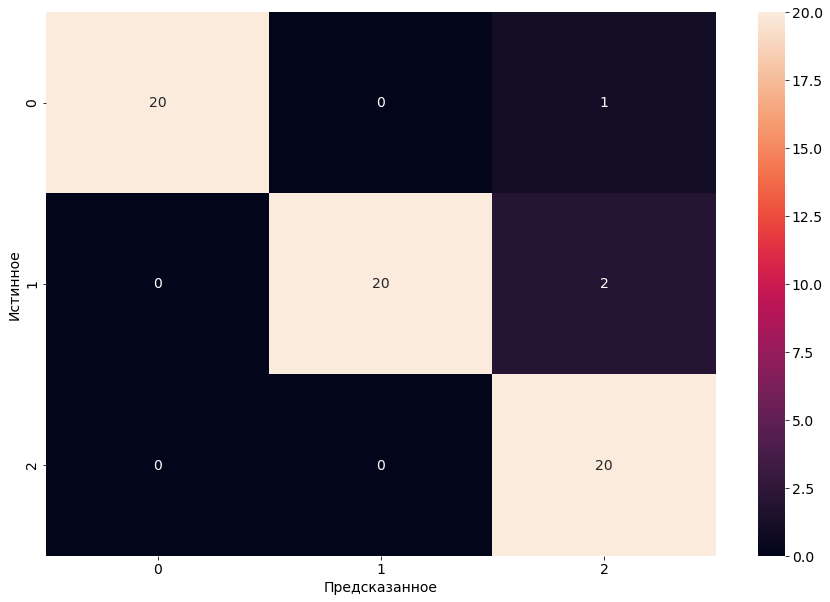

In [29]:
# Проверим
logreg_model = LogisticRegression()
logreg_model.fit(
    X_train, y_train,
    lr=0.01,
    n_iter=100
)

y_pred=logreg_model.predict(X_test)

print(f'Accuracy: {calculate_accuracy(y_test, y_pred)}')
print(f'Class 0 metrics: {calculate_recall_precision_f1(y_test, y_pred, 0)}')
print(f'Class 1 metrics: {calculate_recall_precision_f1(y_test, y_pred, 1)}')
print(f'Class 2 metrics: {calculate_recall_precision_f1(y_test, y_pred, 2)}')

conf_mtrx = get_confusion_matrix(y_test, y_pred)
draw_confusion_matrix(conf_mtrx)

# Задание


Произведите оценку работы модели с использованием кросс-валидации и класса LogisticRegression. В качестве метрики для оценки используйте среднюю F1 по всем классам.

In [30]:
# TODO - функция оценки работы модели кросс-валидацией с пятью фолдами 
# NOTE - не забудьте зафиксировать RANDOM_STATE
from sklearn.model_selection import StratifiedKFold 

# NOTE - обратите внимание, в качестве агрумента передаем модель, 
#   которую будем проверять
def cross_val_score_f1(X, y, k_folds, model):
    f1_values = []
    skf = StratifiedKFold(n_splits=k_folds,random_state=RANDOM_STATE)
    for train_index, test_index in skf.split(X,y):
        X_train=X[train_index]
        X_test=X[test_index]
        y_train=y[train_index]
        y_test=y[test_index]
        
        loss_history = model.fit(
        lr=0.01,
        n_iter=100,
        X=X_train,
        y=y_train)
        y_pred = model.predict(X_test)
        
        for i in range(np.max(y_test)+1):
            recall,precision,f1=calculate_recall_precision_f1(y_test,y_pred,i)
            f1_values.append(f1)

    return np.mean(f1_values)

In [31]:
# Используем!
logreg_model = LogisticRegression()

f1_result = cross_val_score_f1(X_data, y_data, k_folds=5, model=logreg_model)
print(f1_result)

C:\Users\ksyus\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.952026571980595


# Выводы-задания

**1. В каких случаях необходимо использовать мультиноминальную классификацию?**

**Ответ** Мультиклассовая классификация отличается от ранее расмотренныхтем, что тут уже моэет фигурировать не два класса, а много больше. И выбрать необходимо один класс из всех доступных.

**2. Что позволяет оценить функция потерь? И зачем нужна эта оценка?**

**Ответ** Функция потерь дает возможность произвести оценку того, насколько совпадает вектор предсказанных значений с вектором истинных значений. В ходе обучения требуется свести функцию потерь к минимуму.

**3. Как это "обучение с учителем"?** 

**Ответ** под учителем будем понимать некоторую обучающую выборку, которая будем являться желаемой целью нашего обучения. По сути, процесс обучения с учителем это процесс, когда мы пытаемся достичь этой желаемой выборки (например, изменяя веса целевого функционала).

# Вопросы

**1. Что используется в мультиноминальной классификации вместо сигмоиды?** - В данном случае вместо сигмоиды используется функция Softmax.

**2. Почему MSE для случае мутиноминальной классификации - не лучший выбор?** -у MSE расстояние между индексами 0 и 2 будут больше, чем расстояние между 0 и 1, что вносит искажение в смысл, так как классы по факту должны быть равнозначны.

**3. Что такое ОНЕ и где это использовать?** - One-Hot Encoding - это метод кодирования категориальных переменных в числовые данные, с которыми могут работать алгоритмы машинного обучения. Суть OHE метода заключается в том, что каждый индекс класс в векторе мы заменяем на вектор, состоящий из нулей и единиц. Делается это путем размещения единицы в векторе на место по индексу номера класса. Используется для кодирования классов, когда нет порядковых отношений между классами и необходимо все классы сделать равнозначными.

**4. В чём категориальность категориальной кросс-энтропии?**  - Категориальная кросс-энтропия - это функция потерь, которая используется в задачах мультиноминальной классификации, а которых как раз и требуется чтобы модель определила к какой из множества категорий принадлежит выбранный объект. Категориальная кросс-энтропия хорошо подходит для задач классификации, так как один объект можно рассматривать как принадлежащий к определенной категории с вероятностью 1 и к другим категориям с вероятностью 0.

**5. Зачем оборачивать модель логистической регрессии в класс? Какие преимущества это даёт?** - Это необходимо для упрощения кода, осбенно очень большого.По сути мы можем ипользовать необходимые нам функци без передачи в нее параметров, которые используются только внутри нее. Это делает код компактным, что улучшает его читаемость.